In [ ]:

import sys
import os
if os.path.dirname(os.path.abspath('')) not in sys.path:
    sys.path.insert(0, os.path.dirname(os.path.abspath('')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.io import load_data, load_pairs
from utils.config import get_stock_data_path

data = load_data(get_stock_data_path())
# Ensure Date is a proper datetime index for plotting
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.set_index('Date').sort_index()
elif not isinstance(data.index, pd.DatetimeIndex):
    # Fallback: try to parse index if it's date-like strings
    try:
        data.index = pd.to_datetime(data.index, errors='coerce')
        data = data.sort_index()
    except Exception:
        pass

pairs = load_pairs('../analysis/cointegrated_pairs.pkl')

print("Data loaded")
print(f"Pairs: {len(pairs)} | Days: {len(data)}")

Data loaded
Pairs: 10 | Days: 480


In [ ]:

from utils.spread import calculate_spread


def compute_spread_with_intercept(df: pd.DataFrame, t1: str, t2: str, hr: float, alpha: float) -> pd.Series:
    """Compute intercept-aware log spread: log(p1) - (alpha + hr*log(p2))."""
    log_p1 = np.log(df[f"Close__{t1}"])
    log_p2 = np.log(df[f"Close__{t2}"])
    return log_p1 - (alpha + hr * log_p2)


def calculate_zscore(spread: pd.Series, window: int = 60) -> pd.Series:
    """Calculate rolling z-score with a default window that avoids lookahead changes."""
    rolling_mean = spread.rolling(window).mean()
    rolling_std = spread.rolling(window).std()
    return (spread - rolling_mean) / rolling_std


def generate_positions(z: pd.Series, entry: float = 2.0, exit: float = 0.5) -> pd.Series:
    """Generate position signals from z-scores (1 long spread, -1 short spread)."""
    pos = pd.Series(0.0, index=z.index)
    current = 0.0
    for i in range(len(z)):
        zi = z.iloc[i]
        if np.isnan(zi):
            pos.iloc[i] = 0.0
            continue
        if zi > entry:
            current = -1.0
        elif zi < -entry:
            current = 1.0
        elif abs(zi) < exit:
            current = 0.0
        pos.iloc[i] = current
    return pos


def backtest_pairs_weights(df: pd.DataFrame, s1: str, s2: str, hr: float, pos: pd.Series, cost: float = 0.0005):
    """
    Weight-based two-leg backtest with proper cost alignment and capital normalization.
    - Weights per $1 capital: w1 = pos/(1+|hr|), w2 = -hr*pos/(1+|hr|)
    - Execution at t+1: use shifted weights and costs
    - Costs proportional to turnover: |Δw1| + |Δw2|
    """
    r1 = df[f"Close__{s1}"].pct_change()
    r2 = df[f"Close__{s2}"].pct_change()
    pos = pos.reindex(r1.index).fillna(0.0)
    denom = 1.0 + abs(hr)
    w1 = pos / denom
    w2 = -hr * pos / denom
    w1_exec = w1.shift(1).fillna(0.0)
    w2_exec = w2.shift(1).fillna(0.0)
    daily_raw = (w1_exec * r1) + (w2_exec * r2)
    tw1 = w1.diff().abs().fillna(0.0)
    tw2 = w2.diff().abs().fillna(0.0)
    turnover = (tw1 + tw2).shift(1).fillna(0.0)
    tx_costs = cost * turnover
    daily_ret = (daily_raw - tx_costs).fillna(0.0)
    valid = r1.notna() & r2.notna()
    daily_ret_v = daily_ret[valid]
    cum = (1.0 + daily_ret_v).cumprod()
    sharpe = (daily_ret_v.mean() / daily_ret_v.std() * np.sqrt(252)) if daily_ret_v.std() > 0 else 0.0
    active_mask = (w1_exec.abs() + w2_exec.abs()) > 0.0
    active_ret = daily_ret_v[active_mask.reindex(daily_ret_v.index).fillna(False)]
    sharpe_act = (active_ret.mean() / active_ret.std() * np.sqrt(252)) if len(active_ret) and active_ret.std() > 0 else 0.0
    tot_ret = float(cum.iloc[-1] - 1.0) if len(cum) else 0.0
    dd = (cum - cum.cummax()) / cum.cummax() if len(cum) else cum
    max_dd = float(dd.min()) if len(dd) else 0.0
    n_trades = int((pos.diff().abs() > 0).sum())
    return {
        "Sharpe": float(sharpe), "SharpeActive": float(sharpe_act),
        "TotalReturn": tot_ret, "MaxDrawdown": max_dd,
        "NumTrades": n_trades, "WinRate": 0.0,  # trade-level win rate computed separately
        "Capital": denom, "Cumulative": cum, "DailyReturn": daily_ret_v, "Drawdown": dd,
        "Weights": {"w1": w1, "w2": w2}
    }


def compute_trade_metrics(daily_ret: pd.Series, pos: pd.Series) -> dict:
    """Compute trade-level metrics from executed positions and daily returns."""
    if daily_ret is None or pos is None:
        return {"NumTrades": 0, "WinRate": 0.0, "AvgTradeReturn": 0.0, "MedianTradeReturn": 0.0, "AvgHoldDays": 0.0}
    exec_pos = pos.reindex(daily_ret.index).shift(1).fillna(0.0)
    mask_active = exec_pos != 0.0
    if not mask_active.any():
        return {"NumTrades": 0, "WinRate": 0.0, "AvgTradeReturn": 0.0, "MedianTradeReturn": 0.0, "AvgHoldDays": 0.0}
    regime_change = (exec_pos != exec_pos.shift(1)).astype(int)
    trade_id = regime_change.cumsum()
    ret_active = daily_ret[mask_active]
    id_active = trade_id[mask_active]
    trade_returns = ret_active.groupby(id_active).apply(lambda x: float((1.0 + x).prod() - 1.0))
    trade_durations = ret_active.groupby(id_active).size()
    num_trades = int(len(trade_returns))
    win_rate = float(((trade_returns > 0.0).sum() / num_trades)) if num_trades > 0 else 0.0
    avg_trade_ret = float(trade_returns.mean()) if num_trades > 0 else 0.0
    median_trade_ret = float(trade_returns.median()) if num_trades > 0 else 0.0
    avg_hold_days = float(trade_durations.mean()) if num_trades > 0 else 0.0
    return {
        "NumTrades": num_trades,
        "WinRate": win_rate,
        "AvgTradeReturn": avg_trade_ret,
        "MedianTradeReturn": median_trade_ret,
        "AvgHoldDays": avg_hold_days,
    }

print("Functions loaded")


Functions loaded


In [ ]:
all_results = []

print("\nRunning backtest...")
for i, p in enumerate(pairs, 1):
    s1, s2 = p['tickers']
    hr = p['hedge_ratio']
    alpha = p.get('intercept', 0.0)

    spread_series = compute_spread_with_intercept(data, s1, s2, hr, alpha)
    z = calculate_zscore(spread_series, window=60)
    pos = generate_positions(z, entry=1.5, exit=0.0)
    res = backtest_pairs_weights(data, s1, s2, hr, pos, cost=0.0005)

    # Trade-level metrics
    trade_stats = compute_trade_metrics(res['DailyReturn'], pos)
    res['NumTrades'] = trade_stats['NumTrades']
    res['WinRate'] = trade_stats['WinRate']
    res['AvgTradeReturn'] = trade_stats['AvgTradeReturn']
    res['MedianTradeReturn'] = trade_stats['MedianTradeReturn']
    res['AvgHoldDays'] = trade_stats['AvgHoldDays']
    res['Position'] = pos  # store for diagnostics
    
    all_results.append({
        'Pair': f"{s1} vs {s2}", 'HedgeRatio': hr, 'PValue': p['pvalue'],
        'Capital': res['Capital'], 'Sharpe': res['Sharpe'],
        'TotalReturn': res['TotalReturn'], 'MaxDrawdown': res['MaxDrawdown'],
        'NumTrades': res['NumTrades'], 'WinRate': res['WinRate'],
        'AvgTradeReturn': res['AvgTradeReturn'], 'MedianTradeReturn': res['MedianTradeReturn'], 'AvgHoldDays': res['AvgHoldDays'],
        'Results': res
    })
    
    print(f"[{i}] {s1:5s} vs {s2:5s} | Sharpe: {res['Sharpe']:6.3f} | "
          f"Return: {res['TotalReturn']:7.2%} | Capital: {res['Capital']:.2f}x")

print("\nComplete")



Running backtest...
[1] GOOGL vs ANET  | Sharpe:  0.200 | Return:   3.88% | Capital: 1.43x
[2] V     vs ADBE  | Sharpe:  1.442 | Return:  64.63% | Capital: 1.62x
[3] MA    vs SAP   | Sharpe:  1.073 | Return:  25.89% | Capital: 1.47x
[4] MA    vs META  | Sharpe:  1.065 | Return:  28.69% | Capital: 1.46x
[5] V     vs CSCO  | Sharpe:  0.388 | Return:   6.45% | Capital: 1.82x
[6] AAPL  vs INTC  | Sharpe:  0.246 | Return:   5.99% | Capital: 1.27x
[7] MA    vs ADBE  | Sharpe:  0.180 | Return:   3.12% | Capital: 1.55x
[8] SAP   vs SNAP  | Sharpe:  1.136 | Return:  75.95% | Capital: 1.55x
[9] META  vs SNAP  | Sharpe:  0.345 | Return:  11.88% | Capital: 1.50x
[10] UBER  vs SNAP  | Sharpe:  1.256 | Return: 107.41% | Capital: 1.26x

Complete


In [ ]:

df = pd.DataFrame([{
    'Pair': r['Pair'], 'Capital': r['Capital'], 'Sharpe': r['Sharpe'],
    'Return': r['TotalReturn'], 'MaxDD': r['MaxDrawdown'],
    'WinRate': r['WinRate'], 'Trades': r['NumTrades'],
    'AvgTrade': r.get('AvgTradeReturn', np.nan), 'MedianTrade': r.get('MedianTradeReturn', np.nan), 'AvgHold': r.get('AvgHoldDays', np.nan)
} for r in all_results]).sort_values('Sharpe', ascending=False)

print("\n" + "="*90)
print("WEIGHT-BASED PERFORMANCE (NO LOOKAHEAD IN COSTS)")
print("="*90)
print(df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*90)

print(f"\nMean Sharpe: {df['Sharpe'].mean():.3f} | "
      f"Mean Return: {df['Return'].mean():.2%} | "
      f"Profitable: {(df['Return']>0).sum()}/{len(df)}")



WEIGHT-BASED PERFORMANCE (NO LOOKAHEAD IN COSTS)
         Pair  Capital  Sharpe  Return   MaxDD  WinRate  Trades  AvgTrade  MedianTrade  AvgHold
    V vs ADBE   1.6245  1.4423  0.6463 -0.1574   0.8750       8    0.0656       0.0749  50.0000
 UBER vs SNAP   1.2575  1.2562  1.0741 -0.1669   0.8889       9    0.0866       0.0953  43.5556
  SAP vs SNAP   1.5543  1.1359  0.7595 -0.1868   0.7500       8    0.0766       0.1030  49.7500
    MA vs SAP   1.4729  1.0726  0.2589 -0.0947   0.6667       9    0.0266       0.0327  43.8889
   MA vs META   1.4623  1.0653  0.2869 -0.0768   1.0000       8    0.0322       0.0234  49.3750
    V vs CSCO   1.8176  0.3877  0.0645 -0.1138   0.6667       6    0.0110       0.0174  65.8333
 META vs SNAP   1.5009  0.3450  0.1188 -0.2921   0.5714       7    0.0192       0.0046  60.0000
 AAPL vs INTC   1.2660  0.2459  0.0599 -0.2327   0.5000       6    0.0141       0.0000  64.0000
GOOGL vs ANET   1.4278  0.2004  0.0388 -0.1603   0.5714       7    0.0062       0.0032

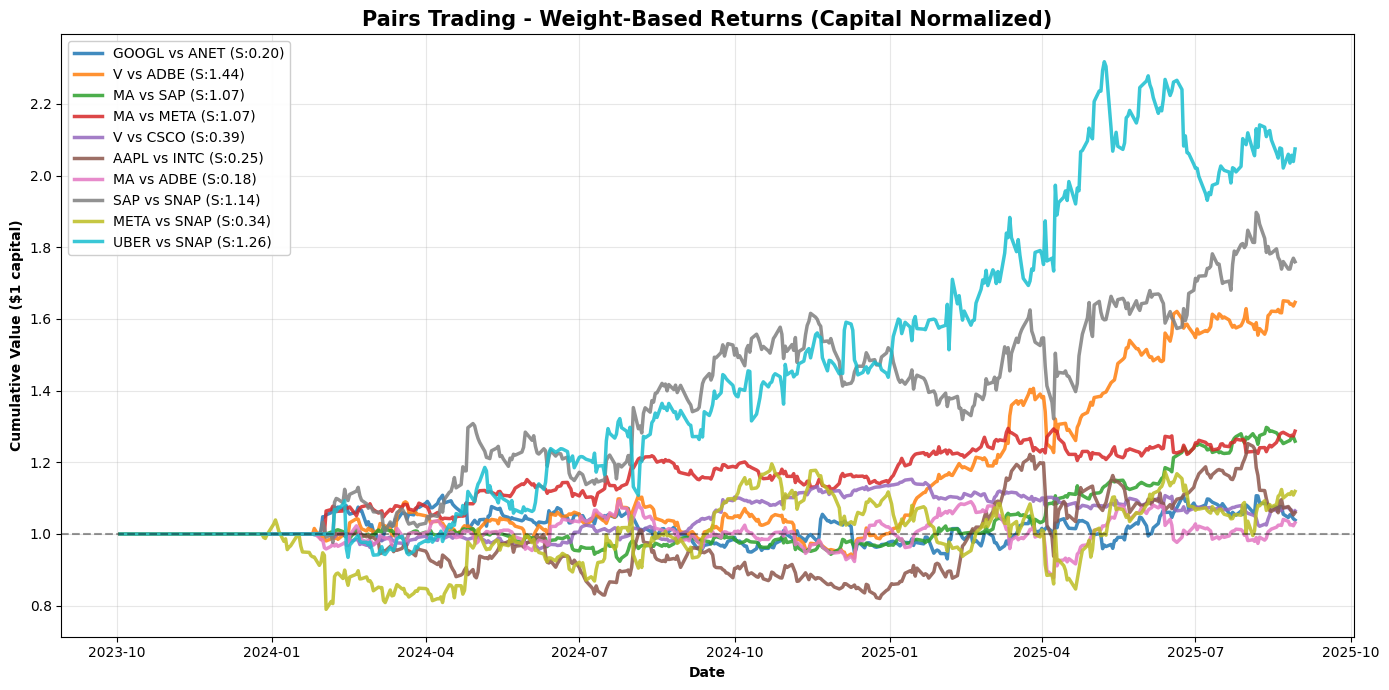

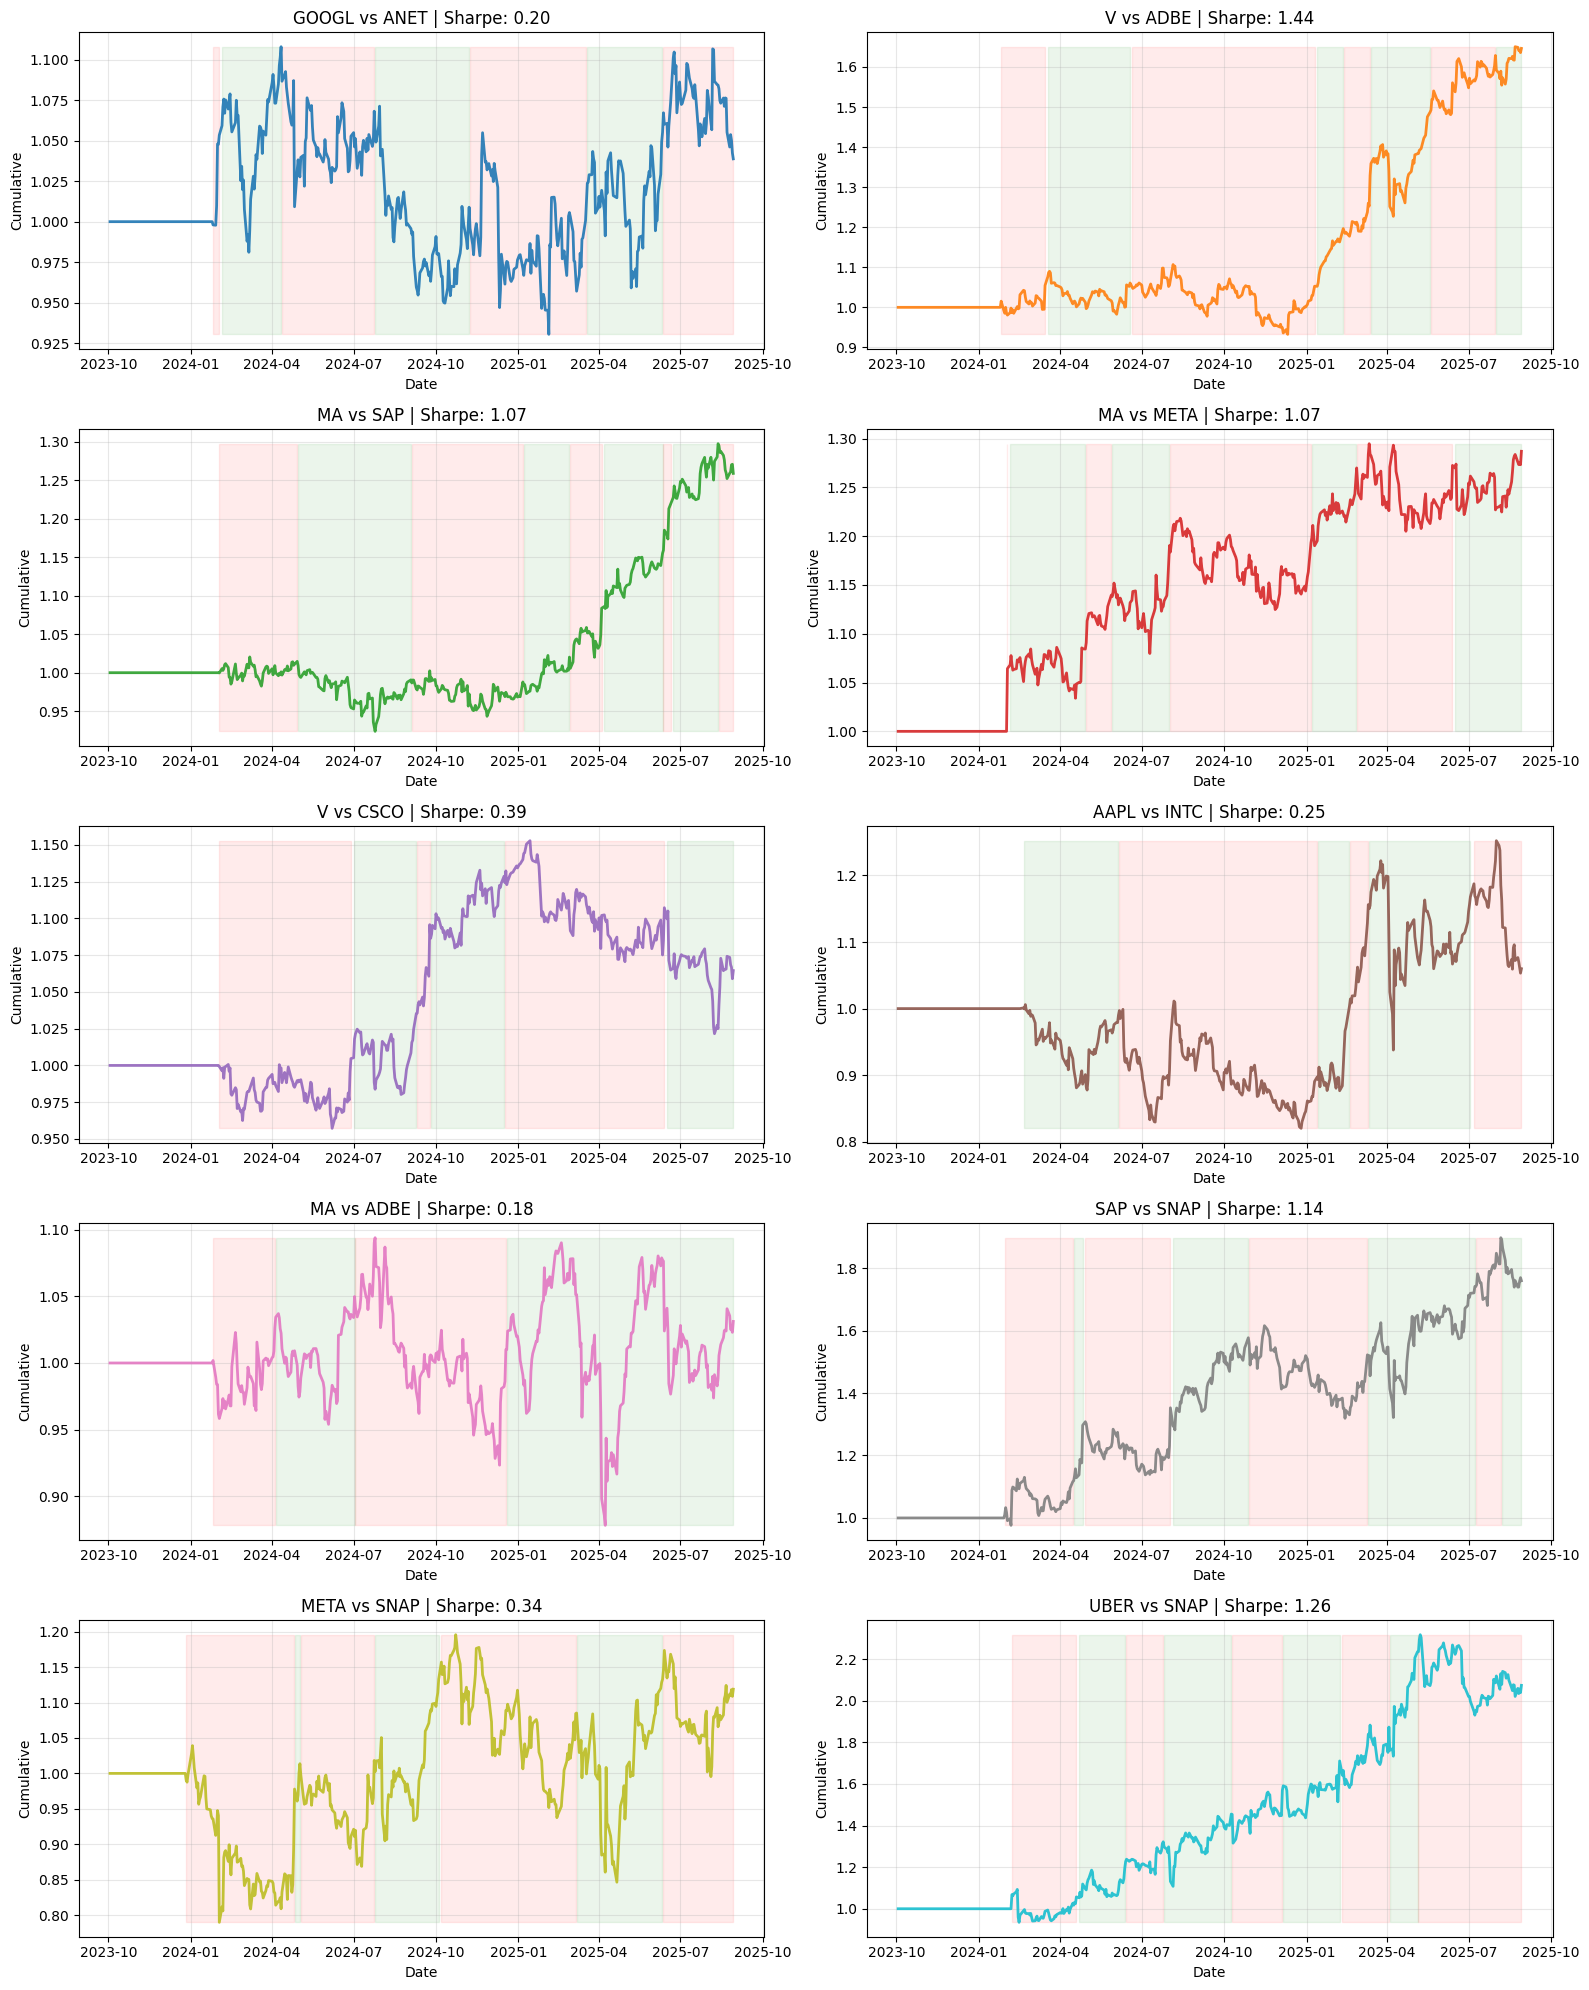

Returns computed as w1*r1 + w2*r2 with costs on turnover


In [ ]:

fig, ax = plt.subplots(figsize=(14, 7))
# Dynamic color cycle for any number of pairs
num_series = len(all_results)
cmap = plt.get_cmap('tab10' if num_series <= 10 else 'tab20')
colors = [cmap(i % cmap.N) for i in range(num_series)]

for i, r in enumerate(all_results):
    c = r['Results']['Cumulative']
    ax.plot(c.index, c.values, lw=2.5, label=f"{r['Pair']} (S:{r['Sharpe']:.2f})",
            color=colors[i % len(colors)], alpha=0.85)

ax.axhline(1, color='black', ls='--', alpha=0.4, lw=1.5)
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Cumulative Value ($1 capital)', fontweight='bold')
ax.set_title('Pairs Trading - Weight-Based Returns (Capital Normalized)', fontsize=15, fontweight='bold')
ax.legend(loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Separate charts per pair with long/short shading
n_pairs = len(all_results)
n_cols = 2
n_rows = (n_pairs + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows), sharex=False)

for idx, (ax, r) in enumerate(zip(axes.flat, all_results)):
    cum = r['Results']['Cumulative']
    pos = r['Results'].get('Position')
    if pos is not None:
        pos_exec = pos.reindex(cum.index).shift(1).fillna(0.0)
    else:
        pos_exec = cum*0.0
    long_mask = pos_exec > 0.0
    short_mask = pos_exec < 0.0
    ymin, ymax = float(cum.min()), float(cum.max())

    ax.plot(cum.index, cum.values, linewidth=2, color=colors[idx % len(colors)], alpha=0.9)
    # Background shading for regimes
    ax.fill_between(cum.index, ymin, ymax, where=long_mask.reindex(cum.index).fillna(False),
                    color='green', alpha=0.08)
    ax.fill_between(cum.index, ymin, ymax, where=short_mask.reindex(cum.index).fillna(False),
                    color='red', alpha=0.08)

    ax.set_title(f"{r['Pair']} | Sharpe: {r['Sharpe']:.2f}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative')
    ax.grid(True, alpha=0.3)

# Hide extra subplot axes if any
extra = len(axes.flat) - n_pairs
if extra > 0:
    for k in range(1, extra+1):
        axes.flat[-k].set_visible(False)

plt.tight_layout()
plt.show()

print("Returns computed as w1*r1 + w2*r2 with costs on turnover")


In [ ]:

print("\n" + "="*90)
print("SUMMARY")
print("="*90)
for r in sorted(all_results, key=lambda x: x['Sharpe'], reverse=True):
    print(f"  {r['Pair']:18s} | HR:{r['HedgeRatio']:7.4f} | "
          f"Cap:{r['Capital']:6.3f}x | S:{r['Sharpe']:6.3f} | R:{r['TotalReturn']:7.2%}")
print("="*90)



SUMMARY
  V vs ADBE          | HR:-0.6245 | Cap: 1.624x | S: 1.442 | R: 64.63%
  UBER vs SNAP       | HR:-0.2575 | Cap: 1.257x | S: 1.256 | R:107.41%
  SAP vs SNAP        | HR:-0.5543 | Cap: 1.554x | S: 1.136 | R: 75.95%
  MA vs SAP          | HR: 0.4729 | Cap: 1.473x | S: 1.073 | R: 25.89%
  MA vs META         | HR: 0.4623 | Cap: 1.462x | S: 1.065 | R: 28.69%
  V vs CSCO          | HR: 0.8176 | Cap: 1.818x | S: 0.388 | R:  6.45%
  META vs SNAP       | HR:-0.5009 | Cap: 1.501x | S: 0.345 | R: 11.88%
  AAPL vs INTC       | HR:-0.2660 | Cap: 1.266x | S: 0.246 | R:  5.99%
  GOOGL vs ANET      | HR: 0.4278 | Cap: 1.428x | S: 0.200 | R:  3.88%
  MA vs ADBE         | HR:-0.5464 | Cap: 1.546x | S: 0.180 | R:  3.12%


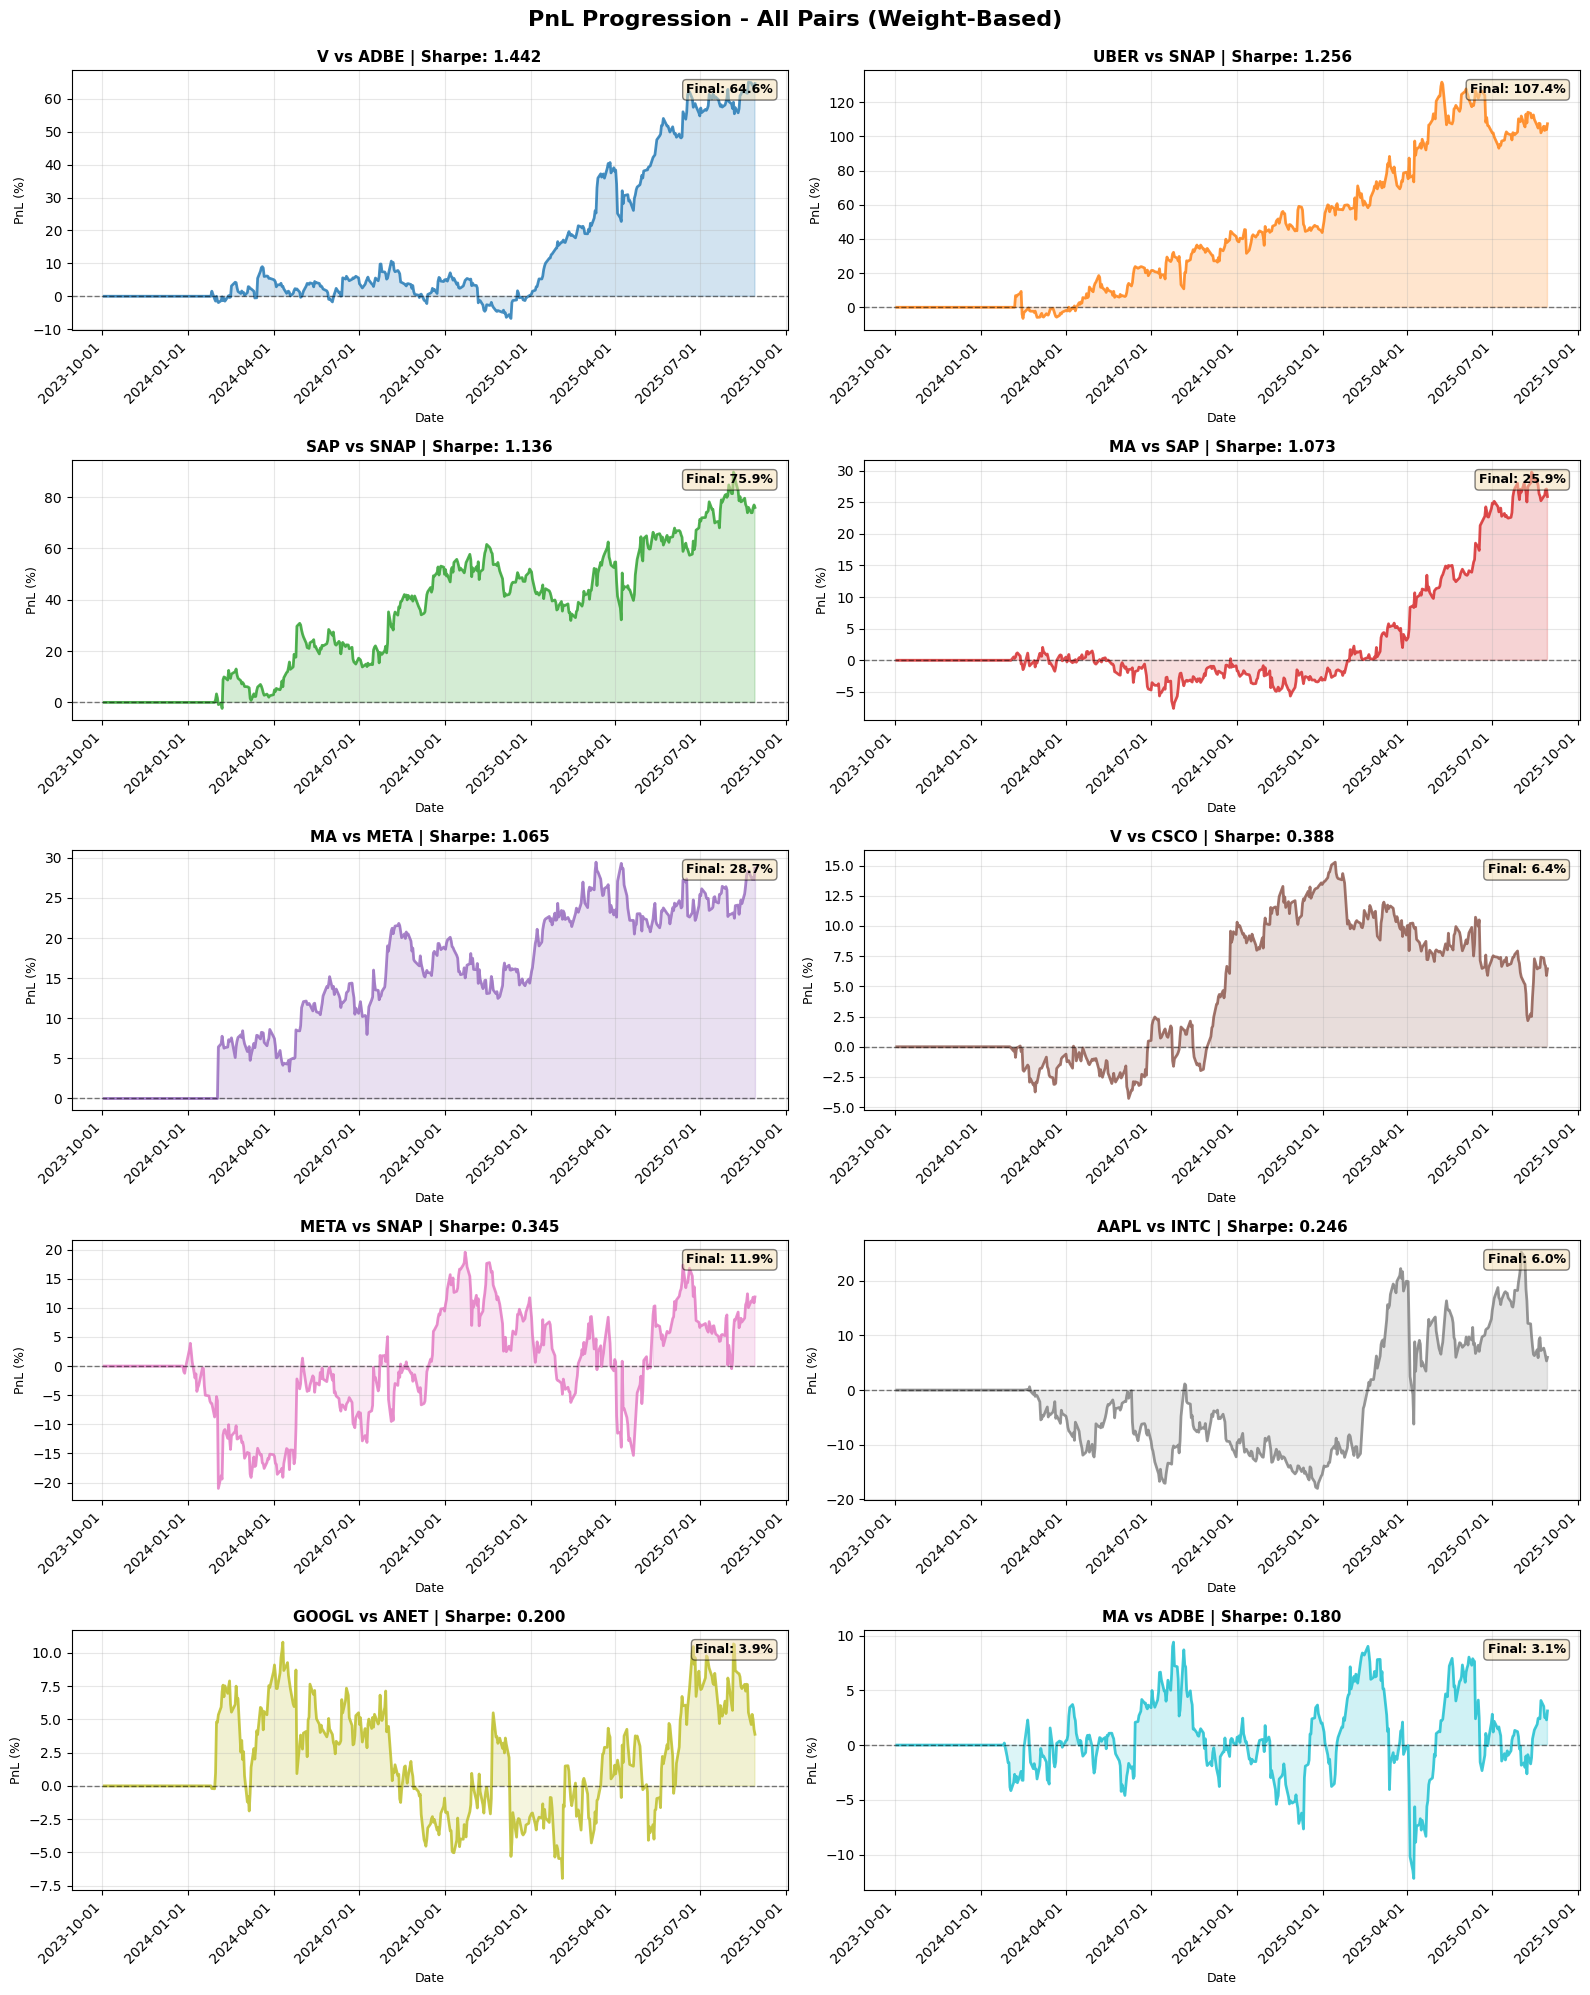


PNL SUMMARY
+ V vs ADBE          | PnL:   64.63% | Per $100: $  64.63 | Sharpe:  1.442
+ UBER vs SNAP       | PnL:  107.41% | Per $100: $ 107.41 | Sharpe:  1.256
+ SAP vs SNAP        | PnL:   75.95% | Per $100: $  75.95 | Sharpe:  1.136
+ MA vs SAP          | PnL:   25.89% | Per $100: $  25.89 | Sharpe:  1.073
+ MA vs META         | PnL:   28.69% | Per $100: $  28.69 | Sharpe:  1.065
+ V vs CSCO          | PnL:    6.45% | Per $100: $   6.45 | Sharpe:  0.388
+ META vs SNAP       | PnL:   11.88% | Per $100: $  11.88 | Sharpe:  0.345
+ AAPL vs INTC       | PnL:    5.99% | Per $100: $   5.99 | Sharpe:  0.246
+ GOOGL vs ANET      | PnL:    3.88% | Per $100: $   3.88 | Sharpe:  0.200
+ MA vs ADBE         | PnL:    3.12% | Per $100: $   3.12 | Sharpe:  0.180


In [ ]:

# Dynamic grid for any number of pairs (2 columns)
n_pairs = len(all_results)
n_cols = 2
n_rows = (n_pairs + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
fig.suptitle('PnL Progression - All Pairs (Weight-Based)', fontsize=16, fontweight='bold', y=0.995)

# Sort by Sharpe for better visualization order
sorted_pairs = sorted(all_results, key=lambda x: x['Sharpe'], reverse=True)

for idx, (ax, r) in enumerate(zip(axes.flat, sorted_pairs)):
    # Calculate PnL from cumulative returns
    cum = r['Results']['Cumulative']
    pnl = (cum - 1) * 100  # PnL in percentage terms
    
    # Convert index to datetime if it's not already
    if not isinstance(pnl.index, pd.DatetimeIndex):
        pnl.index = pd.to_datetime(pnl.index)
    
    # Color based on performance (use colormap cycle)
    cmap = plt.get_cmap('tab10' if len(sorted_pairs) <= 10 else 'tab20')
    color = cmap(idx % cmap.N)
    
    # Plot PnL
    ax.plot(pnl.index, pnl.values, linewidth=2, color=color, alpha=0.8)
    ax.fill_between(pnl.index, 0, pnl.values, 
                     where=(pnl.values >= 0), alpha=0.2, color=color,
                     label='Profit')
    ax.fill_between(pnl.index, 0, pnl.values, 
                     where=(pnl.values < 0), alpha=0.15, color=color,
                     label='Loss')
    
    # Zero line
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Formatting
    ax.set_title(f"{r['Pair']} | Sharpe: {r['Sharpe']:.3f}", 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Date', fontsize=9)
    ax.set_ylabel('PnL (%)', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add final PnL annotation
    final_pnl = pnl.iloc[-1]
    ax.text(0.98, 0.95, f'Final: {final_pnl:.1f}%',
            transform=ax.transAxes, fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            verticalalignment='top', horizontalalignment='right')

# Hide extra subplot if odd number of pairs
if len(sorted_pairs) < len(axes.flat):
    axes.flat[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Print PnL summary
print("\n" + "="*90)
print("PNL SUMMARY")
print("="*90)
for r in sorted_pairs:
    cum = r['Results']['Cumulative']
    initial = 1.0
    final = cum.iloc[-1] if len(cum) > 0 else 1.0
    pnl_pct = (final - initial) * 100
    pnl_dollar = (final - initial) * 100  # Per $100 invested
    
    status = "+" if pnl_pct > 0 else "-"
    print(f"{status} {r['Pair']:18s} | PnL: {pnl_pct:>7.2f}% | "
          f"Per $100: ${pnl_dollar:>7.2f} | Sharpe: {r['Sharpe']:>6.3f}")
print("="*90)


In [ ]:

import numpy as np

rows = []
for r in all_results:
    pair = r['Pair']
    res = r['Results']
    daily = res['DailyReturn']
    pos = res.get('Position', None)

    if daily is None or len(daily) == 0:
        continue

    ann_r = (1 + daily.mean())**252 - 1
    ann_vol = daily.std() * np.sqrt(252)
    cagr = (1 + daily).cumprod().iloc[-1]**(252/len(daily)) - 1
    cum = (1 + daily).cumprod()
    running_max = cum.cummax()
    max_dd = float((cum - running_max).min())

    active_mask = pos.reindex(daily.index).shift(1).fillna(0.0) != 0.0 if pos is not None else daily * 0 == 1
    active_frac = float(active_mask.mean()) if len(active_mask) else 0.0

    # trade-level metrics already computed
    rows.append({
        'Pair': pair,
        'Sharpe': r['Sharpe'],
        'TotalReturn': r['TotalReturn'],
        'AnnReturn': float(ann_r),
        'AnnVol': float(ann_vol),
        'CAGR': float(cagr),
        'MaxDD': max_dd,
        'ActiveFrac': active_frac,
        'Trades': r['NumTrades'],
        'AvgTrade': r.get('AvgTradeReturn', np.nan),
        'MedianTrade': r.get('MedianTradeReturn', np.nan),
        'AvgHold': r.get('AvgHoldDays', np.nan),
    })

import pandas as pd
Dx = pd.DataFrame(rows).sort_values('Sharpe', ascending=False)

# Flags
Dx['Flag_Lumpy'] = (Dx['TotalReturn'] > 0.5) & (Dx['Sharpe'] < 0.9)
Dx['Flag_Noise'] = (Dx['Sharpe'] < 0.2) & (Dx['TotalReturn'].abs() < 0.1)
Dx['Flag_Negative'] = Dx['TotalReturn'] < 0

print("\n" + "="*90)
print("DIAGNOSTICS")
print("="*90)
print(Dx[['Pair','Sharpe','TotalReturn','AnnReturn','AnnVol','CAGR','MaxDD','ActiveFrac','Trades','AvgTrade','MedianTrade','AvgHold','Flag_Lumpy','Flag_Noise','Flag_Negative']]
      .to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*90)

# Quick lists
print("\nFlags:")
print("- Lumpy (high PnL, low Sharpe):", ", ".join(Dx.loc[Dx['Flag_Lumpy'],'Pair'].tolist()) or "None")
print("- Noise (low Sharpe, small PnL):", ", ".join(Dx.loc[Dx['Flag_Noise'],'Pair'].tolist()) or "None")
print("- Negative PnL:", ", ".join(Dx.loc[Dx['Flag_Negative'],'Pair'].tolist()) or "None")




DIAGNOSTICS
         Pair  Sharpe  TotalReturn  AnnReturn  AnnVol   CAGR   MaxDD  ActiveFrac  Trades  AvgTrade  MedianTrade  AvgHold  Flag_Lumpy  Flag_Noise  Flag_Negative
    V vs ADBE  1.4423       0.6463     0.3245  0.1950 0.2999 -0.1792      0.8351       8    0.0656       0.0749  50.0000       False       False          False
 UBER vs SNAP  1.2562       1.0741     0.5631  0.3559 0.4678 -0.3867      0.8184       9    0.0866       0.0953  43.5556       False       False          False
  SAP vs SNAP  1.1359       0.7595     0.4068  0.3007 0.3461 -0.3036      0.8309       8    0.0766       0.1030  49.7500       False       False          False
    MA vs SAP  1.0726       0.2589     0.1368  0.1196 0.1288 -0.0966      0.8246       9    0.0266       0.0327  43.8889       False       False          False
   MA vs META  1.0653       0.2869     0.1519  0.1328 0.1419 -0.0936      0.8246       8    0.0322       0.0234  49.3750       False       False          False
    V vs CSCO  0.3877      